In [1]:
import numpy as np
import pandas as pd
import os
import yaml
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from load_data.prepared_custom_ds import CustomDataset

import torch
import torchvision
from torchvision.transforms import Resize
import time
import os.path as osp
from tqdm import tqdm

# Tests

In [116]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [132]:
mask.shape

(768, 768)

In [82]:
norm_image = image / 127.5 - 1

In [33]:
np.transpose(image, (2, 0, 1)).shape

(3, 768, 768)

In [108]:
resizer = Resize([256, 256]) 

In [118]:
res_im = resizer(torch.tensor(np.transpose(image_rgb, (2, 0, 1))))

In [124]:
res_im

tensor([[[ 59,  64,  57,  ...,  69,  61,  64],
         [ 52,  64,  63,  ...,  65,  59,  59],
         [ 60,  56,  81,  ...,  60,  65,  60],
         ...,
         [ 53,  58,  64,  ...,  61,  63,  68],
         [ 86,  70,  59,  ...,  87,  61,  60],
         [ 65,  67,  69,  ...,  52,  53,  66]],

        [[ 80,  85,  78,  ...,  97,  89,  92],
         [ 75,  87,  86,  ...,  93,  87,  87],
         [ 83,  79, 104,  ...,  88,  93,  88],
         ...,
         [ 79,  84,  90,  ...,  89,  93,  98],
         [112,  96,  85,  ..., 115,  91,  90],
         [ 91,  93,  95,  ...,  80,  83,  96]],

        [[ 97, 102,  95,  ..., 111, 103, 106],
         [ 91, 103, 102,  ..., 107, 101, 101],
         [ 99,  95, 120,  ..., 102, 107, 102],
         ...,
         [ 96, 101, 107,  ..., 101, 104, 109],
         [129, 113, 102,  ..., 127, 102, 101],
         [108, 110, 112,  ...,  92,  94, 107]]], dtype=torch.uint8)

In [134]:
mask.shape

(768, 768)

In [139]:
torch.tensor(mask).unsqueeze(0).shape

torch.Size([1, 768, 768])

In [140]:
res_mask = resizer(torch.tensor(mask).unsqueeze(0))

C:\Users\da4nik\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [145]:
for i in res_mask[0]:
    for j in i:
        if j != 0.0:
            print(j)

tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)

In [125]:
norm_rim = res_im / 127.5 - 1

In [126]:
norm_rim

tensor([[[-0.5373, -0.4980, -0.5529,  ..., -0.4588, -0.5216, -0.4980],
         [-0.5922, -0.4980, -0.5059,  ..., -0.4902, -0.5373, -0.5373],
         [-0.5294, -0.5608, -0.3647,  ..., -0.5294, -0.4902, -0.5294],
         ...,
         [-0.5843, -0.5451, -0.4980,  ..., -0.5216, -0.5059, -0.4667],
         [-0.3255, -0.4510, -0.5373,  ..., -0.3176, -0.5216, -0.5294],
         [-0.4902, -0.4745, -0.4588,  ..., -0.5922, -0.5843, -0.4824]],

        [[-0.3725, -0.3333, -0.3882,  ..., -0.2392, -0.3020, -0.2784],
         [-0.4118, -0.3176, -0.3255,  ..., -0.2706, -0.3176, -0.3176],
         [-0.3490, -0.3804, -0.1843,  ..., -0.3098, -0.2706, -0.3098],
         ...,
         [-0.3804, -0.3412, -0.2941,  ..., -0.3020, -0.2706, -0.2314],
         [-0.1216, -0.2471, -0.3333,  ..., -0.0980, -0.2863, -0.2941],
         [-0.2863, -0.2706, -0.2549,  ..., -0.3725, -0.3490, -0.2471]],

        [[-0.2392, -0.2000, -0.2549,  ..., -0.1294, -0.1922, -0.1686],
         [-0.2863, -0.1922, -0.2000,  ..., -0

In [97]:
tensor = transforms(image)

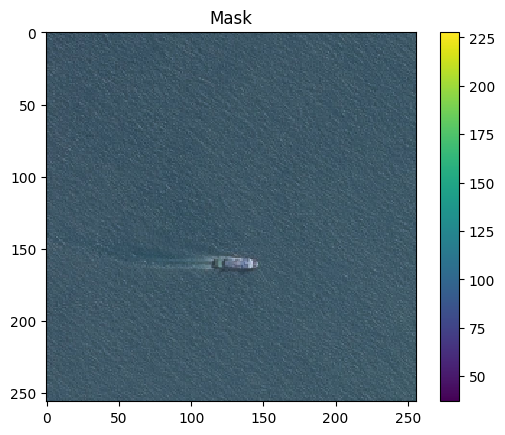

In [123]:
plt.imshow(np.array(res_im.permute(1, 2, 0)), interpolation='nearest')
plt.title('Mask')
plt.colorbar()
plt.show()

In [61]:
tesnor_mask = transforms(mask)

In [72]:
tesnor_mask.shape

torch.Size([1, 256, 256])

# Load config

In [7]:
CONFIG_PATH = "configs/"
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)
    return config

config = load_config("config.yaml")

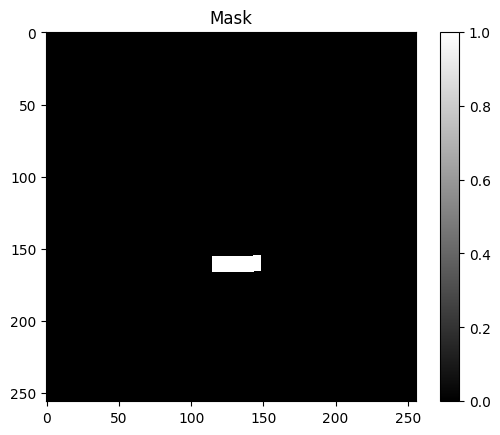

In [68]:
plt.imshow(np.array(tesnor_mask).reshape((256, 256)), cmap='gray', interpolation='nearest')
plt.title('Mask')
plt.colorbar()
plt.show()

# Dataloader

In [10]:
test = cv2.imread(config['dataset']['reshaped_img_path'] + "/" + img_ids[2])

In [11]:
test.shape

(256, 256, 3)

In [4]:
dataset = CustomDataset(config)
dataloader = DataLoader(dataset, batch_size=1000) # + num thread num_workers=6,

In [5]:
start = time.time()
for pos, i in enumerate(dataloader):
    print((start - time.time()) / (pos + 1))

-1.8243467807769775
-1.774867057800293
-1.7100296815236409
-1.68511301279068
-1.6784914493560792
-1.6926424503326416
-1.701321772166661
-1.6982032358646393
-1.6947779125637479
-1.6846360206604003
-1.6766108599576084
-1.6683395902315776
-1.6627120604881873
-1.6594459499631609
-1.6555434862772624
-1.6592836678028107
-1.6613966857685762
-1.6583489576975505
-1.6576659177478992
-1.6592015981674195
-1.656685431798299
-1.65567101131786
-1.65217896129774
-1.6500615974267323
-1.6552350807189942
-1.6548941410504854
-1.65552525167112
-1.6569313151495797
-1.6576018826714878
-1.656478460629781
-1.66350890744117
-1.6644736900925636
-1.6626823670936353
-1.6604669584947473
-1.658549554007394
-1.6596282588111029
-1.6618921305682208
-1.6600622942573147
-1.6572234936249561
-1.6550267457962036
-1.652784335904005
-1.651103445461818
-1.648923169734866
-1.6471661816943775
-1.645259189605713
-1.6436308052228845
-1.6423270955998848
-1.641411115725835
-1.6516982925181487
-1.6725964593887328
-1.6941068125706094


# Data read

In [5]:
train_ship_data = pd.read_csv("dataset/train_ship_segmentations_v2.csv")

In [8]:
labels = list(pd.read_csv(osp.join(config['dataset']['dir_path'], 
                                                'train_ship_segmentations_v2.csv'))["EncodedPixels"].fillna('').str.split())
img_ids = list(pd.read_csv(osp.join(config['dataset']['dir_path'], 
                                                'train_ship_segmentations_v2.csv'))["ImageId"])

In [13]:
resizer = Resize([config['new_img_size'], config['new_img_size']])

In [19]:
torch.save(torch.zeros(3, 4, 5), 'dataset/tensor.pth')

In [26]:
masks = list()
images = list()
for label, img_id in tqdm(zip(labels, img_ids), total=len(labels)):
    mask = Create_mask(label, config['original_img_size'])
    tensor_mask = resizer(torch.tensor(mask).unsqueeze(0))

    image = cv2.imread(config['dataset']['train_img_path'] + "/" + img_id)
    res_im = resizer(torch.tensor(np.transpose(image, (2, 0, 1))))
    norm_image = res_im / 127.5 - 1
    
    masks.append(tensor_mask)
    images.append(norm_image)
    print(norm_image.shape)
    print(tensor_mask.shape)

  0%|                                                                              | 16/231723 [00:00<50:16, 76.82it/s]

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


  0%|                                                                              | 24/231723 [00:00<55:18, 69.81it/s]

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


  0%|                                                                              | 42/231723 [00:00<50:04, 77.12it/s]

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


  0%|                                                                              | 58/231723 [00:00<50:14, 76.84it/s]

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


  0%|                                                                              | 74/231723 [00:00<49:51, 77.42it/s]

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


  0%|                                                                              | 91/231723 [00:01<49:11, 78.47it/s]

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


  0%|                                                                             | 107/231723 [00:01<50:15, 76.80it/s]

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


  0%|                                                                             | 124/231723 [00:01<49:00, 78.75it/s]

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


  0%|                                                                             | 134/231723 [00:01<50:09, 76.95it/s]

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


KeyboardInterrupt: 

In [28]:
temp = img_ids[90157:]

In [30]:
temp[0]

'63849d9ce.jpg'

In [35]:
for img_id in tqdm(temp):
    image = cv2.imread(config['dataset']['train_img_path'] + "/" + img_id)
    res_im = resizer(torch.tensor(np.transpose(image, (2, 0, 1))))
    perm_im = res_im.permute(1, 2, 0)
    cv2.imwrite(config['dataset']['reshaped_img_path'] + "/" + img_id, np.uint8(perm_im.numpy()))

100%|██████████████████████████████████████████████████████████████████████████| 141566/141566 [50:30<00:00, 46.71it/s]


In [46]:
test = Create_mask(labels[2], config['original_img_size']) 

In [49]:
m = resizer(torch.tensor(test).unsqueeze(0))

In [18]:
test_image = torchvision.io.read_image(config['dataset']['reshaped_img_path'] + "/" + img_ids[2]).to(torch.float32)

In [19]:
test_image.shape

torch.Size([3, 256, 256])

In [29]:
test = torchvision.io.read_image(config['dataset']['mask_path'] + "/mask" + img_ids[2])

In [30]:
test.shape

torch.Size([1, 256, 256])

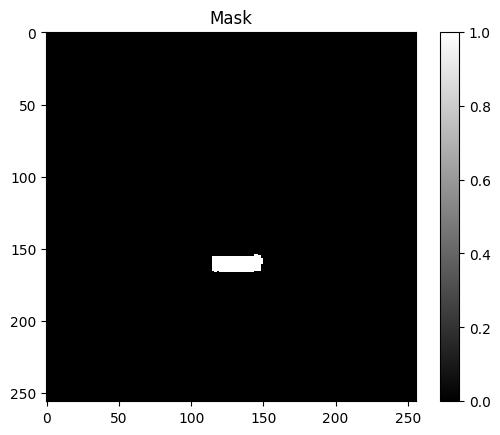

In [32]:
plt.imshow(np.array(test.permute(1, 2, 0)), cmap='gray', interpolation='nearest')
plt.title('Mask')
plt.colorbar()
plt.show()

In [25]:
for img_id in tqdm(img_ids):
    image = torchvision.io.read_image(config['dataset']['mask_path'] + "/mask" + img_id)
    #image = cv2.imread(config['dataset']['reshaped_img_path'] + "/" + img_id)

100%|█████████████████████████████████████████████████████████████████████████| 231723/231723 [05:57<00:00, 648.54it/s]


In [14]:
for label, img_id in tqdm(zip(labels, img_ids), total=len(labels)):
    mask = Create_mask(label, config['original_img_size'])
    res_mask = resizer(torch.tensor(mask).unsqueeze(0))
    perm_mask = res_mask.permute(1, 2, 0)
    print(res_mask.max())
    #cv2.imwrite(config['dataset']['mask_path'] + "/" + "mask" + img_id, np.uint8(perm_mask.numpy()))

  0%|                                                                                       | 0/231723 [00:00<?, ?it/s]C:\Users\da4nik\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|                                                                            | 128/231723 [00:00<05:46, 668.87it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  0%|                                                                            | 285/231723 [00:00<05:11, 743.63it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  0%|▏                                                                           | 442/231723 [00:00<05:00, 768.95it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  0%|▏                                                                           | 603/231723 [00:00<04:53, 786.93it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  0%|▏                                                                           | 757/231723 [00:01<05:22, 717.01it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  0%|▎                                                                           | 908/231723 [00:01<05:15, 730.53it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  0%|▎                                                                          | 1075/231723 [00:01<04:55, 780.05it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▍                                                                          | 1232/231723 [00:01<04:59, 770.87it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▍                                                                          | 1476/231723 [00:01<04:55, 780.14it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▌                                                                          | 1634/231723 [00:02<04:58, 771.32it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▌                                                                          | 1712/231723 [00:02<04:58, 769.32it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▌                                                                          | 1877/231723 [00:02<04:48, 797.69it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▋                                                                          | 2050/231723 [00:02<04:52, 784.16it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▋                                                                          | 2211/231723 [00:02<04:55, 776.55it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  1%|▊                                                                          | 2376/231723 [00:03<04:47, 798.45it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▊                                                                          | 2538/231723 [00:03<04:50, 789.46it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  1%|▊                                                                          | 2698/231723 [00:03<04:49, 789.76it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  1%|▉                                                                          | 2863/231723 [00:03<04:43, 806.22it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  1%|▉                                                                          | 3028/231723 [00:03<04:48, 793.89it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  1%|█                                                                          | 3189/231723 [00:04<04:46, 796.59it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  1%|█                                                                          | 3357/231723 [00:04<04:46, 797.67it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▏                                                                         | 3516/231723 [00:04<04:51, 782.41it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▏                                                                         | 3675/231723 [00:04<04:52, 779.42it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▏                                                                         | 3837/231723 [00:04<04:47, 791.47it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  2%|█▎                                                                         | 3917/231723 [00:05<04:48, 789.27it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▎                                                                         | 4154/231723 [00:05<05:21, 708.47it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  2%|█▍                                                                         | 4307/231723 [00:05<05:10, 732.83it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▍                                                                         | 4457/231723 [00:05<05:07, 739.73it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▍                                                                         | 4612/231723 [00:06<05:00, 756.54it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  2%|█▌                                                                         | 4689/231723 [00:06<05:07, 738.64it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▌                                                                         | 4858/231723 [00:06<04:53, 773.99it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▋                                                                         | 5027/231723 [00:06<04:40, 809.29it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▋                                                                         | 5190/231723 [00:06<04:48, 784.82it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  2%|█▋                                                                         | 5362/231723 [00:06<04:36, 817.86it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  2%|█▊                                                                         | 5528/231723 [00:07<04:38, 812.35it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  2%|█▊                                                                         | 5690/231723 [00:07<04:50, 777.37it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|█▉                                                                         | 5868/231723 [00:07<04:41, 802.89it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|█▉                                                                         | 6034/231723 [00:07<04:39, 806.58it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██                                                                         | 6204/231723 [00:08<04:33, 823.25it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  3%|██                                                                         | 6367/231723 [00:08<04:55, 763.83it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██                                                                         | 6540/231723 [00:08<04:35, 818.04it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▏                                                                        | 6719/231723 [00:08<04:22, 858.61it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  3%|██▏                                                                        | 6896/231723 [00:08<04:18, 871.36it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  3%|██▎                                                                        | 7071/231723 [00:09<04:26, 843.95it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▎                                                                        | 7332/231723 [00:09<04:20, 862.81it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▍                                                                        | 7512/231723 [00:09<04:15, 876.91it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▍                                                                        | 7693/231723 [00:09<04:11, 891.47it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▌                                                                        | 7871/231723 [00:09<04:15, 876.88it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  3%|██▌                                                                        | 7959/231723 [00:10<04:20, 857.44it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  4%|██▋                                                                        | 8127/231723 [00:10<04:36, 809.63it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|██▋                                                                        | 8290/231723 [00:10<04:41, 792.85it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  4%|██▋                                                                        | 8449/231723 [00:10<04:46, 779.51it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|██▊                                                                        | 8612/231723 [00:10<04:41, 792.80it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|██▊                                                                        | 8772/231723 [00:11<04:41, 790.72it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|██▉                                                                        | 8929/231723 [00:11<04:58, 746.33it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|██▉                                                                        | 9083/231723 [00:11<04:53, 758.14it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  4%|██▉                                                                        | 9240/231723 [00:11<04:48, 771.08it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|███                                                                        | 9401/231723 [00:11<04:41, 788.74it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|███                                                                        | 9565/231723 [00:12<04:40, 791.80it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|███▏                                                                       | 9726/231723 [00:12<04:38, 797.93it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  4%|███▏                                                                       | 9896/231723 [00:12<04:32, 812.72it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  4%|███▏                                                                      | 10059/231723 [00:12<04:36, 801.22it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  4%|███▎                                                                      | 10230/231723 [00:12<04:36, 800.61it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  4%|███▎                                                                      | 10391/231723 [00:13<04:41, 785.67it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  5%|███▎                                                                      | 10549/231723 [00:13<04:46, 771.88it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▍                                                                      | 10705/231723 [00:13<04:51, 757.16it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  5%|███▍                                                                      | 10937/231723 [00:13<04:49, 762.54it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▌                                                                      | 11099/231723 [00:14<04:41, 785.07it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▌                                                                      | 11257/231723 [00:14<04:44, 776.16it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▌                                                                      | 11344/231723 [00:14<04:34, 803.76it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▋                                                                      | 11503/231723 [00:14<04:48, 764.26it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▋                                                                      | 11670/231723 [00:14<04:35, 798.91it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▊                                                                      | 11913/231723 [00:15<04:38, 787.96it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  5%|███▊                                                                      | 11992/231723 [00:15<04:42, 777.11it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  5%|███▉                                                                      | 12163/231723 [00:15<04:38, 787.42it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|███▉                                                                      | 12321/231723 [00:15<04:40, 782.21it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  5%|████                                                                      | 12562/231723 [00:15<04:35, 796.20it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  5%|████                                                                      | 12726/231723 [00:16<04:40, 781.06it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  6%|████                                                                      | 12883/231723 [00:16<04:43, 770.74it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  6%|████▏                                                                     | 13039/231723 [00:16<04:46, 763.55it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  6%|████▏                                                                     | 13116/231723 [00:16<04:50, 752.16it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▏                                                                     | 13297/231723 [00:16<04:22, 833.32it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▎                                                                     | 13464/231723 [00:17<04:33, 799.20it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▎                                                                     | 13623/231723 [00:17<04:50, 751.54it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▍                                                                     | 13776/231723 [00:17<04:54, 739.95it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▍                                                                     | 13924/231723 [00:17<05:07, 707.99it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  6%|████▍                                                                     | 14082/231723 [00:17<04:50, 748.53it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▌                                                                     | 14237/231723 [00:18<04:45, 762.76it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  6%|████▌                                                                     | 14395/231723 [00:18<04:39, 776.44it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▋                                                                     | 14556/231723 [00:18<04:35, 788.93it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▋                                                                     | 14723/231723 [00:18<04:27, 810.58it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▋                                                                     | 14805/231723 [00:18<04:27, 810.57it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  6%|████▊                                                                     | 15051/231723 [00:19<04:57, 728.19it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  7%|████▊                                                                     | 15209/231723 [00:19<04:46, 754.94it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|████▉                                                                     | 15289/231723 [00:19<04:41, 767.86it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|████▉                                                                     | 15451/231723 [00:19<04:33, 790.29it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  7%|████▉                                                                     | 15607/231723 [00:19<05:07, 703.39it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  7%|█████                                                                     | 15758/231723 [00:20<05:00, 718.71it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████                                                                     | 15900/231723 [00:20<05:21, 672.31it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████▏                                                                    | 16049/231723 [00:20<05:02, 712.32it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████▏                                                                    | 16200/231723 [00:20<04:58, 721.60it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████▏                                                                    | 16365/231723 [00:21<04:37, 776.52it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  7%|█████▎                                                                    | 16519/231723 [00:21<04:58, 720.88it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  7%|█████▎                                                                    | 16665/231723 [00:21<04:59, 717.61it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████▎                                                                    | 16820/231723 [00:21<05:00, 714.58it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  7%|█████▍                                                                    | 16972/231723 [00:21<04:52, 733.31it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  7%|█████▍                                                                    | 17123/231723 [00:22<04:49, 742.35it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  7%|█████▌                                                                    | 17275/231723 [00:22<04:48, 744.32it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▌                                                                    | 17442/231723 [00:22<04:37, 772.23it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  8%|█████▌                                                                    | 17601/231723 [00:22<04:38, 768.33it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▋                                                                    | 17758/231723 [00:22<04:40, 762.67it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▋                                                                    | 17925/231723 [00:23<04:27, 797.92it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▊                                                                    | 18084/231723 [00:23<04:33, 782.45it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▊                                                                    | 18243/231723 [00:23<04:34, 777.42it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  8%|█████▉                                                                    | 18400/231723 [00:23<04:38, 765.72it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  8%|█████▉                                                                    | 18656/231723 [00:24<04:21, 816.06it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|██████                                                                    | 18827/231723 [00:24<04:16, 829.40it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  8%|██████                                                                    | 19003/231723 [00:24<04:09, 854.04it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|██████                                                                    | 19089/231723 [00:24<04:15, 830.92it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  8%|██████▏                                                                   | 19253/231723 [00:24<04:29, 788.92it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|██████▏                                                                   | 19416/231723 [00:24<04:24, 803.05it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  8%|██████▎                                                                   | 19581/231723 [00:25<04:22, 806.97it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▎                                                                   | 19753/231723 [00:25<04:14, 832.69it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▍                                                                   | 20014/231723 [00:25<04:08, 851.65it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▍                                                                   | 20186/231723 [00:25<04:10, 843.46it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▍                                                                   | 20271/231723 [00:25<04:19, 816.37it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▌                                                                   | 20432/231723 [00:26<04:42, 746.98it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▌                                                                   | 20580/231723 [00:26<05:07, 687.07it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▌                                                                   | 20650/231723 [00:26<05:23, 653.04it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▋                                                                   | 20780/231723 [00:26<05:33, 633.09it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▋                                                                   | 20907/231723 [00:27<05:42, 615.45it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▋                                                                   | 21037/231723 [00:27<05:34, 630.53it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▊                                                                   | 21168/231723 [00:27<05:29, 639.34it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▊                                                                   | 21297/231723 [00:27<05:39, 620.19it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▊                                                                   | 21433/231723 [00:27<05:24, 647.52it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▊                                                                   | 21500/231723 [00:27<05:21, 654.09it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▉                                                                   | 21688/231723 [00:28<06:06, 572.65it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

  9%|██████▉                                                                   | 21820/231723 [00:28<05:40, 617.26it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

  9%|██████▉                                                                   | 21884/231723 [00:28<05:37, 621.98it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

  9%|███████                                                                   | 22010/231723 [00:28<06:21, 550.34it/s]

tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████                                                                   | 22136/231723 [00:29<05:56, 587.95it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

 10%|███████                                                                   | 22260/231723 [00:29<05:53, 593.17it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▏                                                                  | 22322/231723 [00:29<05:49, 599.15it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▏                                                                  | 22439/231723 [00:29<06:46, 514.81it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▏                                                                  | 22547/231723 [00:29<06:52, 507.69it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

 10%|███████▏                                                                  | 22607/231723 [00:29<06:32, 533.11it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

 10%|███████▎                                                                  | 22785/231723 [00:30<06:25, 541.70it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▎                                                                  | 22850/231723 [00:30<06:05, 572.07it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torc

 10%|███████▎                                                                  | 22982/231723 [00:30<05:44, 605.48it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▍                                                                  | 23123/231723 [00:30<05:18, 655.12it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▍                                                                  | 23274/231723 [00:31<04:57, 701.57it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▌                                                                  | 23493/231723 [00:31<04:54, 705.88it/s]

tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▌                                                                  | 23637/231723 [00:31<04:53, 707.93it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▌                                                                  | 23779/231723 [00:31<04:56, 701.19it/s]

tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torc

 10%|███████▋                                                                  | 23924/231723 [00:31<04:54, 706.33it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▋                                                                  | 24068/231723 [00:32<04:51, 712.60it/s]

tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

 10%|███████▋                                                                  | 24132/231723 [00:32<04:37, 748.85it/s]


tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torch.int8)
tensor(0, dtype=torc

KeyboardInterrupt: 

# Data preview

In [12]:
list(train_ship_data['EncodedPixels'])[0] == None

False

In [9]:
train_ship_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


# Create mask

In [3]:
def Create_mask(labels, img_size):
    mask = np.zeros(img_size*img_size, np.int8)
    if len(labels) > 1:
        np_lbl = np.asarray(labels, dtype=int)
        for i in range(0, len(np_lbl), 2):
            # Create a tuple of even and odd numbers
            start_ind = np_lbl[i]
            end_ind = np_lbl[i] + np_lbl[i + 1]
            mask[start_ind:end_ind] = 1.0

    return mask.reshape((img_size, img_size)).T

In [9]:
mask = Create_mask(train_ship_data.iloc[2]["EncodedPixels"].split(" "), config['original_img_size'])

In [11]:
mask.max()

1

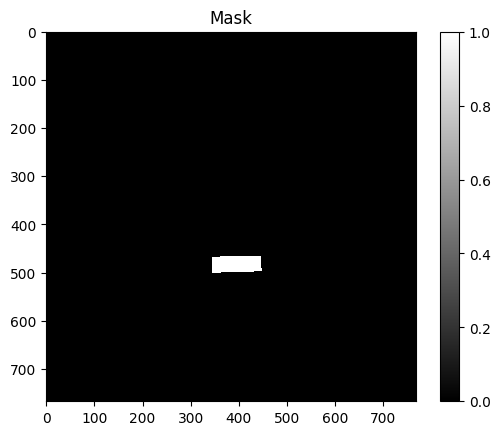

In [10]:
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title('Mask')
plt.colorbar()
plt.show()

# Image

In [14]:
image_tns = torchvision.io.read_image(config['dataset']['train_img_path'] + "/" + train_ship_data.iloc[2]["ImageId"])

In [16]:
resizer = Resize([config['new_img_size'], config['new_img_size']])

In [17]:
res_im = resizer(image_tns)

C:\Users\da4nik\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [22]:
res_im.permute(1, 2, 0).shape

torch.Size([256, 256, 3])

In [10]:
image = cv2.imread(config['dataset']['train_img_path'] + "/" + train_ship_data.iloc[2]["ImageId"])

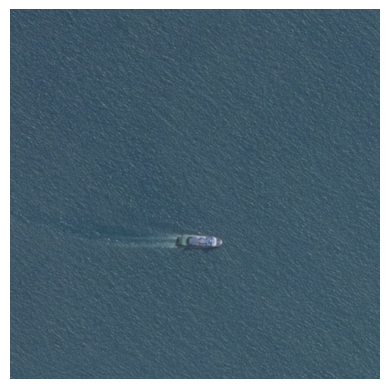

In [91]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis
plt.show()